In [56]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

[saving and loading embedding from Chroma](https://github.com/langchain-ai/langchain/issues/7175)

In [8]:
all_top100s = pd.concat([pd.read_csv('../reddit/top100csvs/'+i,index_col="Unnamed: 0") for i in os.listdir('../reddit/top100csvs/')])
top1k = pd.read_csv("../reddit/top1000_travel_subreddit.csv",index_col=['Unnamed: 0']).sort_values("ups",ascending=False).dropna().rename(columns={'link_flair_css_class':'category'})

reddit_3308_df = pd.concat([all_top100s,top1k]).drop_duplicates()

In [9]:
reddit_3308_df.shape

(3223, 12)

In [10]:
question_loader = DataFrameLoader(reddit_3308_df, page_content_column="selftext")
question_data = question_loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=400,
                                          chunk_overlap=20)
texts = splitter.split_documents(question_data)

In [11]:
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


/Users/christopherton/Desktop/SJSU_MSDA/WanderChat/prot/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [7]:

chromadb_index = Chroma.from_documents(
    texts, embedding_function, 
    persist_directory='/Users/christopherton/Desktop/SJSU_MSDA/WanderChat/vector_db/reddit_chroma_db/'
)


In [8]:
chromadb_index.persist()

In [12]:
db_load = Chroma(persist_directory="/Users/christopherton/Desktop/SJSU_MSDA/WanderChat/vector_db/reddit_chroma_db",embedding_function=embedding_function)

In [82]:
query = "traveling alone through the safari"

docs = db_load.similarity_search(query,k=20)
#docs
docs[0].metadata['title']

'10 Luxury Lodges for an Unforgettable Safari Escape'

In [83]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

In [84]:
# Your query
query_embedding = model.encode([query])

# Assuming `chromadb_index` is your Chroma instance with the documents indexed
results = db_load.similarity_search(query,k=20)

# Collect all embeddings (query + similar docs)
# Assuming `results` contains the indices of the documents in your original dataset (`texts`)
similar_docs_embeddings = [model.encode(i.metadata['title']) for i in results]
all_embeddings = np.vstack([query_embedding, similar_docs_embeddings])

In [88]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Using PCA for dimensionality reduction
# pca = PCA(n_components=2)
# reduced_embeddings = pca.fit_transform(all_embeddings)

reduced_embeddings = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(all_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


https://www.kaggle.com/code/colinmorris/visualizing-embeddings-with-t-sne

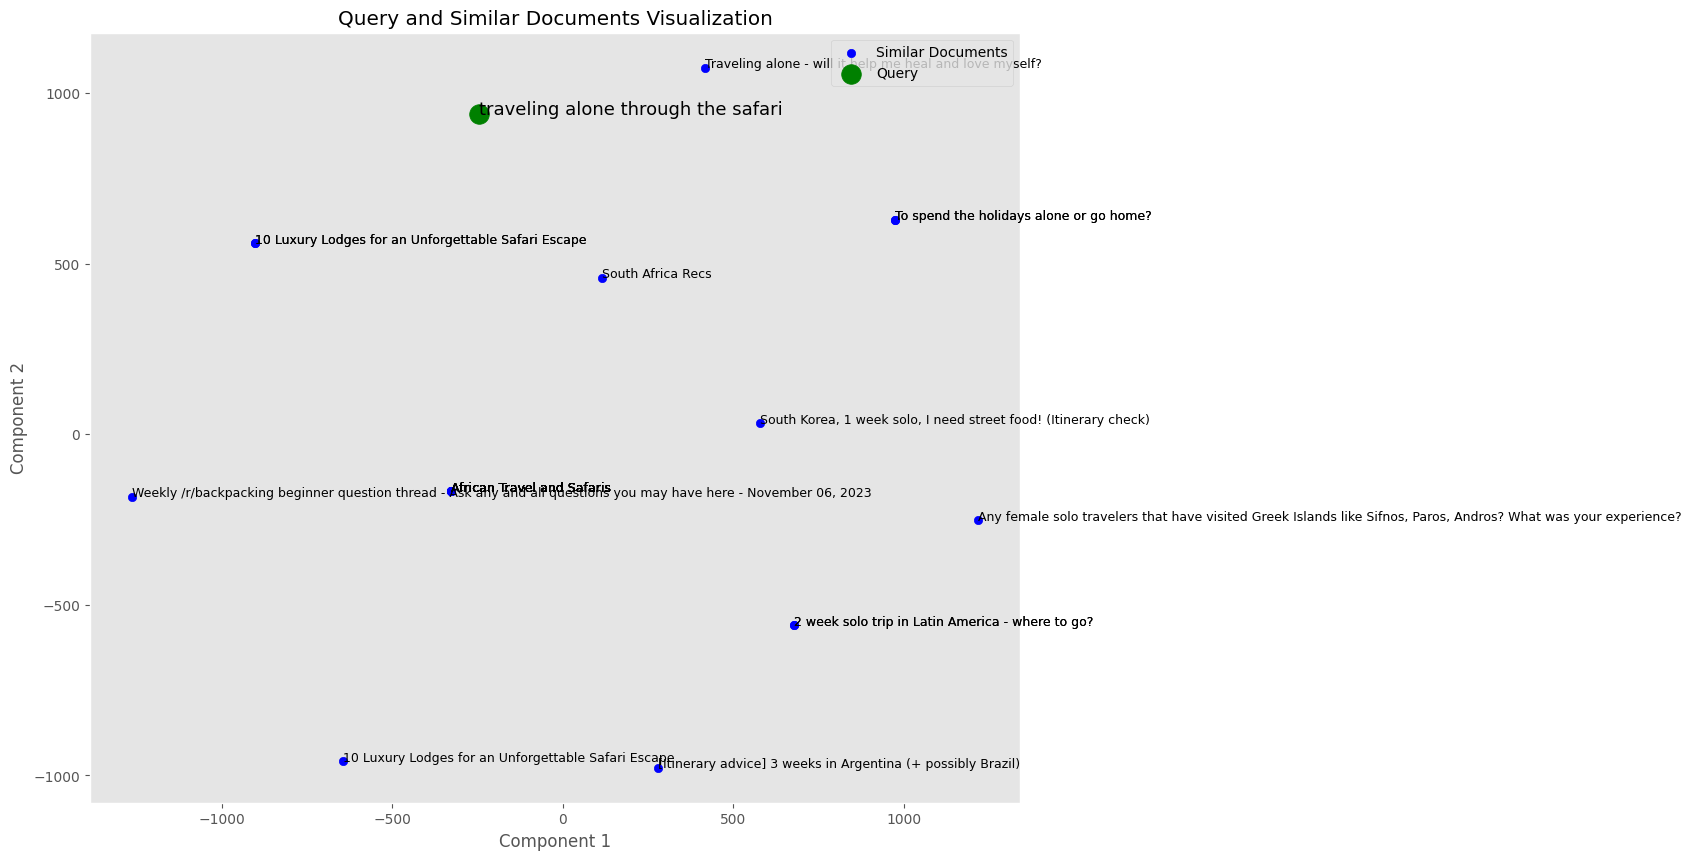

In [99]:
# Colors
query_color = 'green'
result_color = 'blue'


fig, ax = plt.subplots(figsize=(12, 10))
# Plot similar documents
for i, (x, y) in enumerate(reduced_embeddings[1:, :]):  # Skip the first one as it's the query
    plt.scatter(x, y, color=result_color, label='Similar Documents' if i == 0 else "")
    #sns.regplot(x=x, y=y,label='Similar Documents' if i == 0 else "", ax=ax)
#     # Optionally add text labels
    plt.text(x, y, f"{results[i].metadata['title']}", color='black', fontsize=9)

# # Plot the query
plt.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1],s=200, color=query_color, label='Query')
# # Optionally add a label for the query
plt.text(reduced_embeddings[0, 0], reduced_embeddings[0, 1], query, color='black', fontsize=13)


plt.legend()
plt.title('Query and Similar Documents Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(False)  # Optional: Adds a grid for easier visualization
plt.show()